In [7]:
from datasets import Dataset, load_dataset
import numpy as np
import pandas as pd
import joblib, os, sys, time, random, json
from openai import OpenAI
from nltk import sent_tokenize
import spacy
from tqdm.auto import tqdm
import joblib
import matplotlib.pyplot as plt

In [144]:
conflict = pd.DataFrame(load_dataset("Seongill/squad_conflict_v2_under_150_with_substitution", split="train"))
conflict['answer_sent'] = conflict.apply(lambda x: find_answer_sent(x['context'], x['answer']), axis=1)
print(len(conflict))
conflict = conflict.dropna(subset=['answer_sent'])
print(len(conflict))
conflict["rewritten_answer_sent"] = conflict.apply(lambda x: find_answer_sent(x['rewritten_context'], x['answer']), axis=1)
conflict = conflict.dropna(subset=['rewritten_answer_sent'])
print(len(conflict))
conflict['answer_chunk'] = conflict.apply(lambda x: parser_answer_chunk(x['context'], x['answer']), axis=1)
conflict['rewritten_answer_chunk'] = conflict.apply(lambda x: parser_answer_chunk(x['rewritten_context'], x['answer']), axis=1)

25866
25866
25866


In [146]:
Dataset.from_pandas(conflict.drop(columns=["title","__index_level_0__"], axis=1)).push_to_hub("Seongill/squad_conflict_v2_under_150_with_substitution_chunked")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/26 [00:00<?, ?ba/s]

In [2]:
conflict.head()

NameError: name 'conflict' is not defined

In [142]:
conflict

,id,title,context,question,answers,masked_query,query_embedding,ent_type,answer,random_answer,similar_answer,rewritten_context,has_answer,__index_level_0__,answer_sent,rewritten_answer_sent,rewritten_answer_chunk
0,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,"{'answer_start': [279], 'text': ['the Main Bui...",[MASK] at [MASK] is beside to which structure?,"[0.3204971253871918, 0.20272424817085266, 0.22...",FAC,the Main Building,U.S. 1,the Royal Mews,"With its Catholic character, the school's arch...",True,0,Atop the Main Building's gold dome is a golden...,"On top of the Main Building's dome, there is a...","Architecturally, the school has a Catholic cha..."
1,5733bed24776f41900661188,University_of_Notre_Dame,The university is the major seat of the Congre...,Where is the headquarters of the Congregation ...,"{'answer_start': [119], 'text': ['Rome']}",Where is the headquarters of [MASK]?,"[0.3285101652145386, 0.22826211154460907, 0.12...",GPE,Rome,Baden-Württemberg,Antioch,"Moreau Seminary, located on the campus borderi...",True,1,The university is the major seat of the Congre...,Although its official headquarters are in Rome...,The university is the major seat of the Congre...
2,5733bed24776f41900661189,University_of_Notre_Dame,The university is the major seat of the Congre...,What is the primary seminary of the Congregati...,"{'answer_start': [145], 'text': ['Moreau Semin...",What is the primary seminary of [MASK]?,"[0.1649821400642395, 0.1607779562473297, 0.091...",ORG,Moreau Seminary,The Entertainment Channel,Hofstra University,"Moreau Seminary, located on the campus borderi...",True,2,"Its main seminary, Moreau Seminary, is located...","Moreau Seminary, located on the campus borderi...","Old College, the oldest building on campus and..."
3,5733bed24776f4190066118a,University_of_Notre_Dame,The university is the major seat of the Congre...,What is the oldest structure at Notre Dame?,"{'answer_start': [234], 'text': ['Old College']}",What is the oldest structure at [MASK]?,"[-0.02514331042766571, 0.3645743131637573, -0....",ORG,Old College,the Insurance Institute for Highway Safety,Eton College,"Moreau Seminary, located on the campus borderi...",True,3,"Old College, the oldest building on campus and...",Undergraduate seminarians reside in Old Colleg...,The university is the major seat of the Congre...
4,5733a6424776f41900660f51,University_of_Notre_Dame,The College of Engineering was established in ...,How many BS level degrees are offered in the C...,"{'answer_start': [487], 'text': ['eight']}",How many BS level degrees are offered in [MASK...,"[0.6788813471794128, 0.5213160514831543, 0.146...",CARDINAL,eight,2.1 million,over twenty,The College of Engineering was founded in 1920...,True,4,"Today the college, housed in the Fitzpatrick, ...",There are eight B.S.,The College of Engineering was established in ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25861,57378e311c456719005744b1,Force,The origin of electric and magnetic fields wou...,How many scalar equations were formed into a s...,"{'answer_start': [159, 159, 159, 159], 'text':...",How many scalar equations were formed into a s...,"[0.3210879862308502, 0.09044459462165833, 0.41...",CARDINAL,20,sextuple,5 to 7,James Clerk Maxwell was responsible for fully ...,True,26794,The origin of electric and magnetic fields wou...,He was able to unify earlier theories into a s...,The origin of electric and magnetic fields wou...
25862,57378e311c456719005744b2,Force,The origin of electric and magnetic fields wou...,How many vector equations did Heaviside and Gi...,"{'answer_start': [215, 215, 215, 215], 'text':...",How many vector equations did [MASK] and Gibbs...,"[-0.013793256133794785, -0.11560852080583572, ...",CARDINAL,4,"approximately 119,000",5 to 7,James Clerk Maxwell was responsible for fully ...,True,26795,The origin of electric and magneti

In [3]:
squad = pd.DataFrame(load_dataset("Seongill/SQuAD_unique_questions", split="train"))
squad.head(1)

,id,title,context,question,answers,masked_query,query_embedding
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'answer_start': [515], 'text': ['Saint Bernad...",To whom did the Virgin Mary allegedly appear i...,"[-0.04606574401259422, 0.015957484021782875, -..."


In [4]:
df = squad.copy()
df['answer_cnt'] = df['answers'].apply(lambda x: len(list(set(x['text']))))
print(df.shape)
df = df[df.answer_cnt == 1]
print(df.shape)

(97888, 8)
(92286, 8)


In [140]:
def find_answer_sent(context, answer):
    sents = sent_tokenize(context)
    for sent in sents:
        if answer in sent:
            return sent
    return None

def parser_answer_chunk(context, answer):
    sents = sent_tokenize(context)
    for idx, sent in enumerate(sents):
        if answer in sent:
            answer_sent_idx = idx
    start_idx = max(0, answer_sent_idx-3)
    end_idx = min(len(sents), answer_sent_idx+4)
    return ' '.join(sents[start_idx:end_idx])
# df['answer_sent'] = df.apply(lambda x: find_answer_sent(x['context'], x['answers']['text'][0]), axis=1)
# print(len(df))
# df = df.dropna(subset=['answer_sent'])
# print(len(df))
# df['answer_chunk'] = df.apply(lambda x: parser_answer_chunk(x['context'], x['answers']['text'][0]), axis=1)
# df.head(1)

In [6]:
df["answer"] = df["answers"].apply(lambda x: x["text"][0])
df = df.drop(columns=["answers", "answer_cnt"])

In [34]:
df = df.drop(columns=["query_embedding", "masked_query"], axis=1)

In [35]:
df

,id,title,context,question,answer_sent,answer_chunk,answer
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"It is a replica of the grotto at Lourdes, Fran...",Atop the Main Building's gold dome is a golden...,Saint Bernadette Soubirous
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,Immediately in front of the Main Building and ...,"Architecturally, the school has a Catholic cha...",a copper statue of Christ
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,Atop the Main Building's gold dome is a golden...,"Architecturally, the school has a Catholic cha...",the Main Building
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,"Immediately behind the basilica is the Grotto,...","Architecturally, the school has a Catholic cha...",a Marian place of prayer and reflection
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,Atop the Main Building's gold dome is a golden...,"Architecturally, the school has a Catholic cha...",a golden statue of the Virgin Mary
...,...,...,...,...,...,...,...
97880,5737a9afc3c5551400e51f63,Force,The connection between macroscopic nonconserva...,What is the exchange of heat associated with?,The connection between macroscopic nonconserva...,The connection between macroscopic nonconserva...,nonconservative forces
97882,5737a9afc3c5551400e51f65,Force,The connection between macroscopic nonconserva...,What makes energy changes in a closed system?,The connection between macroscopic nonconserva...,The connection between macroscopic nonconserva...,nonconservative forces
97884,5737aafd1c456719005744fc,Force,"The pound-force has a metric counterpart, less...",What is the kilogram-force sometimes reffered ...,"The pound-force has a metric counterpart, less...","The pound-force has a metric counterpart, less...",kilopond
97886,5737aafd1c456719005744fe,Force,"The pound-force has a metric counterpart, less...",What seldom used term of a unit of force equal...,Other arcane units of force include the sthène...,"The pound-force has a metric counterpart, less...",kip


In [2]:
#df.to_csv("squad.csv", index=False)
df = pd.read_csv("squad.csv")

In [14]:
#spacy.prefer_gpu()
nlp = spacy.load("en_core_web_trf")

In [15]:
total_ctxs = list(set(squad.context.tolist()))
BATCH_SIZE = 2000
docs = []
for i in tqdm(range(0, len(total_ctxs), BATCH_SIZE)):
    batch = total_ctxs[i:i+BATCH_SIZE]
    docs.extend(list(nlp.pipe(batch)))

  0%|          | 0/11 [00:00<?, ?it/s]

In [16]:
from collections import defaultdict
ANSWER_POS = ["ADV", "ADJ", "NOUN", "NUM", "SYM", "PROPN"]
ent2text = defaultdict(list)
text2ent = dict()
pos2text = defaultdict(list)
text2pos = dict()
for doc in docs:
    for ent in doc.ents:
        ent2text[ent.label_].append(ent.text)
    for token in doc:
        if not token.ent_type_:
            pos2text[token.pos_].append(token.text)
for k, v in ent2text.items():
    ent2text[k] = list(set(v))
for k, v in ent2text.items():
    for vv in v:
        text2ent[vv] = k
pos2text = {k:list(set(v)) for k, v in pos2text.items() if k in ANSWER_POS}
for k, v in pos2text.items():
    for vv in v:
        text2pos[vv] = k
print(len(text2ent), len(text2pos), len(ent2text), len(pos2text))

95515 50872 18 6


<Axes: xlabel='answer_len'>

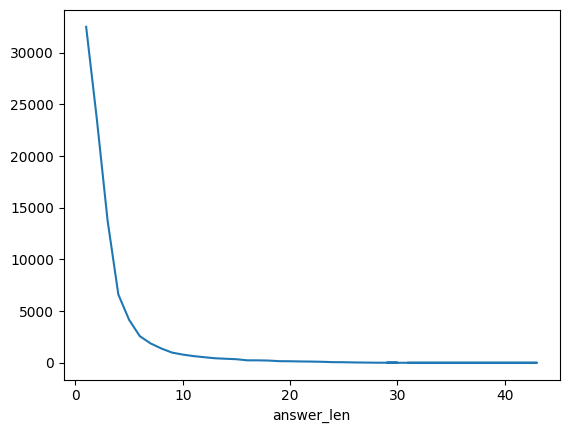

In [54]:
df["answer_len"] = df["answer"].apply(lambda x: len(str(x).split()))
df.answer_len.value_counts().plot()

In [55]:
df[df.answer_len < 5]

,id,title,context,question,answer_sent,answer_chunk,answer,answer_len
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"It is a replica of the grotto at Lourdes, Fran...",Atop the Main Building's gold dome is a golden...,Saint Bernadette Soubirous,3
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,Atop the Main Building's gold dome is a golden...,"Architecturally, the school has a Catholic cha...",the Main Building,3
5,5733bf84d058e614000b61be,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...",When did the Scholastic Magazine of Notre dame...,"Begun as a one-page journal in September 1876,...","As at most other universities, Notre Dame's st...",September 1876,2
6,5733bf84d058e614000b61bf,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...",How often is Notre Dame's the Juggler published?,"Begun as a one-page journal in September 1876,...","As at most other universities, Notre Dame's st...",twice,1
7,5733bf84d058e614000b61c0,University_of_Notre_Dame,"As at most other universities, Notre Dame's st...",What is the daily student paper at Notre Dame ...,The newspapers have varying publication intere...,The newspapers have varying publication intere...,The Observer,2
...,...,...,...,...,...,...,...,...
92059,5737a9afc3c5551400e51f63,Force,The connection between macroscopic nonconserva...,What is the exchange of heat associated with?,The connection between macroscopic nonconserva...,The connection between macroscopic nonconserva...,nonconservative forces,2
92060,5737a9afc3c5551400e51f65,Force,The connection between macroscopic nonconserva...,What makes energy changes in a closed system?,The connection between macroscopic nonconserva...,The connection between macroscopic nonconserva...,nonconservative forces,2
92061,5737aafd1c456719005744fc,Force,"The pound-force has a metric counterpart, less...",What is the kilogram-force sometimes reffered ...,"The pound-force has a metric counterpart, less...","The pound-force has a metric counterpart, less...",kilopond,1
92062,5737aafd1c456719005744fe,Force,"The pound-force has a metric counterpart, less...",What seldom used term of a unit of force equal...,Other arcane units of force include the sthène...,"The pound-force has a metric counterpart, less...",kip,1


In [57]:
BATCH_SIZE = 2000
texts = df[df.answer_len < 5].answer.tolist() + df[df.answer_len < 5].question.tolist()
docs = []
for i in tqdm(range(0, len(texts), BATCH_SIZE)):
    batch = texts[i:i+BATCH_SIZE]
    docs.extend(list(ner.pipe(batch)))

  0%|          | 0/77 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for doc in docs:
    for ent in doc.ents:
        ent2text[ent.label_].append(ent.text)
    for token in doc:
        if not token.ent_type_:
            pos2text[token.pos_].append(token.text)
for k, v in ent2text.items():
    ent2text[k] = list(set(v))
for k, v in ent2text.items():
    for vv in v:
        text2ent[vv] = k
pos2text = {k:list(set(v)) for k, v in pos2text.items() if k in ANSWER_POS}
for k, v in pos2text.items():
    for vv in v:
        text2pos[vv] = k
print(len(text2ent), len(text2pos), len(ent2text), len(pos2text))

In [70]:
nlp = spacy.load("en_core_web_lg")

ent2text_vec = dict()
for k, v in tqdm(ent2text.items()):
    docs  = nlp.pipe(v)
    ent2text_vec[k] = [doc.vector for doc in docs]
docs = nlp.pipe(list(text2ent.keys()))
text2ent_vec = dict()
for doc in docs:
    text2ent_vec[doc.text] = doc.vector
pos2text_vec = dict()
for k, v in tqdm(pos2text.items()):
    docs  = nlp.pipe(v)
    pos2text_vec[k] = [doc.vector for doc in docs]
for k, v in pos2text.items():
    for vv in v:
        text2pos[vv] = k
text2pos_vec = dict()
docs = nlp.pipe(list(text2pos.keys()))
for doc in docs:
    text2pos_vec[doc.text] = doc.vector

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [23]:
print(len(ent2text), len(text2ent), len(pos2text), len(text2pos))
print(len(ent2text_vec), len(text2ent_vec), len(pos2text_vec), len(text2pos_vec))

18 95515 6 50872
18 95515 6 50872


In [76]:

for k, v in tqdm(ent2text_vec.items(), total=len(ent2text_vec), desc="ent2text_vec"):
    normalized = []
    for vv in v:
        numpy_vector = vv.get()
        normalized.append(numpy_vector / np.linalg.norm(numpy_vector))
    ent2text_vec[k] = np.array(normalized)
for k, v in tqdm(pos2text_vec.items(), total=len(pos2text_vec), desc="pos2text_vec"):
    normalized = []
    for vv in v:
        numpy_vector = vv.get()
        normalized.append(numpy_vector / np.linalg.norm(numpy_vector))
    pos2text_vec[k] = np.array(normalized)
joblib.dump(ent2text_vec, "/data/seongil/datasets/ent2text_vec.joblib")
joblib.dump(text2ent_vec, "/data/seongil/datasets/text2ent_vec.joblib")
joblib.dump(pos2text_vec, "/data/seongil/datasets/pos2text_vec.joblib")
joblib.dump(text2pos_vec, "/data/seongil/datasets/text2pos_vec.joblib")

ent2text_vec:   0%|          | 0/18 [00:00<?, ?it/s]

/tmp/ipykernel_2596079/2671793966.py:6: RuntimeWarning: divide by zero encountered in divide
  normalized.append(numpy_vector / np.linalg.norm(numpy_vector))
/tmp/ipykernel_2596079/2671793966.py:6: RuntimeWarning: invalid value encountered in divide
  normalized.append(numpy_vector / np.linalg.norm(numpy_vector))


pos2text_vec:   0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_2596079/2671793966.py:12: RuntimeWarning: divide by zero encountered in divide
  normalized.append(numpy_vector / np.linalg.norm(numpy_vector))
/tmp/ipykernel_2596079/2671793966.py:12: RuntimeWarning: invalid value encountered in divide
  normalized.append(numpy_vector / np.linalg.norm(numpy_vector))


['/data/seongil/datasets/text2pos_vec.joblib']

In [22]:
joblib.dump(ent2text, "/data/seongil/datasets/ent2text.joblib")
joblib.dump(text2ent, "/data/seongil/datasets/text2ent.joblib")
joblib.dump(pos2text, "/data/seongil/datasets/pos2text.joblib")
joblib.dump(text2pos, "/data/seongil/datasets/text2pos.joblib")

['/data/seongil/datasets/text2pos.joblib']

In [65]:
ent2text_vec = joblib.load("/data/seongil/datasets/ent2text_vec.joblib")
text2ent_vec = joblib.load("/data/seongil/datasets/text2ent_vec.joblib")
pos2text_vec = joblib.load("/data/seongil/datasets/pos2text_vec.joblib")
text2pos_vec = joblib.load("/data/seongil/datasets/text2pos_vec.joblib")
ent2text = joblib.load("/data/seongil/datasets/ent2text.joblib")
text2ent = joblib.load("/data/seongil/datasets/text2ent.joblib")
pos2text = joblib.load("/data/seongil/datasets/pos2text.joblib")
text2pos = joblib.load("/data/seongil/datasets/text2pos.joblib")

In [100]:
pos2text["NOUN"].index("state.[citation")


34150

In [105]:
pos2text["NOUN"] = [item for idx, item in enumerate(pos2text["NOUN"]) if idx != 34150]
pos2text_vec["NOUN"] = [item for idx, item in enumerate(pos2text_vec["NOUN"]) if idx != 34150]

In [109]:
pos2text_vec["NOUN"] = cp.array(pos2text_vec["NOUN"])

In [103]:
pos2text["NOUN"].pop(34150)
pos2text_vec["NOUN"].pop(34150)

AttributeError: 'ndarray' object has no attribute 'pop'

In [101]:
a = [12,3]
a.remove(1)

ValueError: list.remove(x): x not in list

In [96]:
text2pos["state.[citation"]

KeyError: 'state.[citation'

In [4]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
wv = KeyedVectors.load_word2vec_format(datapath('/data/seongil/wiki/enwiki_20180420_100d.txt'), binary=False)

In [21]:
wv.similar_by_word("ENTITY/Super_Bowl", topn=10)

[('ENTITY/Super_Bowl_VIII', 0.813761830329895),
 ('ENTITY/Super_Bowl_XXIV', 0.7884112596511841),
 ('ENTITY/AFC_Championship_Game', 0.7823604345321655),
 ('ENTITY/Super_Bowl_XVII', 0.7784186601638794),
 ('ENTITY/Super_Bowl_XVIII', 0.7771480083465576),
 ('ENTITY/Super_Bowl_Most_Valuable_Player_Award', 0.7717746496200562),
 ('ENTITY/National_Football_Conference', 0.7650311589241028),
 ('ENTITY/Super_Bowl_XXVI', 0.7605806589126587),
 ('ENTITY/2005_Pittsburgh_Steelers_season', 0.7526757717132568),
 ('ENTITY/Super_Bowl_IV', 0.7526056170463562)]

In [ ]:
wv.cosine_similarities

In [114]:
wv.similarities(["ENTITY/Super_Bowl"], ["ENTITY/Super_Bowl",'ENTITY/Super_Bowl_Most_Valuable_Player_Award',])

AttributeError: 'KeyedVectors' object has no attribute 'similarities'

In [22]:
ner = spacy.load("en_core_web_trf")
emb = spacy.load("en_core_web_lg")

In [117]:
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-300")

In [130]:
import numpy as cp
import pandas as pd
import random
import numpy as np
import cupy as cp
from numpy.linalg import norm
EDIT_CANDIDATE_POS = ["VERB", "NOUN", "ADJ", "ADV"]
ANSWER_POS = ["ADV", "ADJ", "NOUN", "VERB", "NUM"]
POS_ALIGN = ["VERB", "NOUN", "ADJ"]
from nltk.corpus import wordnet as wn
import random
def _sample_token_same_level_based_on_pos(token, pos):
    possible_candidates = []
    synsets = wn.synsets(token)
    if len(synsets) == 0:
        return possible_candidates
    same_synsets = []
    for synset in synsets:
        if synset.lemma_names()[0] == token and synset.lexname().split(".")[0] == pos:
            same_synsets.append(synset)
    possible_candidates = []
    for synset in same_synsets:
        hypernyms = synset.hypernyms()
        for hyper in hypernyms:
            hypos = hyper.hyponyms()
            hypos = [h.lemma_names()[0].replace("_", " ") for h in hypos if h.lemma_names()[0] != token]
            possible_candidates.extend(hypos)
    return possible_candidates
def find_most_similar(word, word_list,top_n=1):
    """
    주어진 단어와 단어 리스트에서 가장 유사한 top_n 개의 단어들을 찾는 함수.

    :param word: 유사성을 찾을 단어
    :param word_list: 유사성을 비교할 단어 리스트
    :param model: GloVe 모델
    :param top_n: 반환할 상위 단어의 수
    :return: 가장 유사한 top_n 개의 단어 리스트
    """
    # 모델에 없는 단어를 필터링
    word_list = [w for w in word_list if w in model.key_to_index]
    if word_list == []:
        return None
    # 각 단어에 대한 유사도 계산
    similarity_list = [(w, model.similarity(word, w)) for w in word_list]

    # 유사도에 따라 정렬
    sorted_similarity = sorted(similarity_list, key=lambda x: x[1], reverse=True)
    
    # 상위 n개의 단어 반환
    return sorted_similarity[0][0] if sorted_similarity[0][1] > 0.6 else None

def check_cosine_similarity(arr1, arr2, thres):
    cosine_similarity = cp.dot(arr1, arr2) / (norm(arr1) * norm(arr2))
    return (cosine_similarity <= 0.95) and (cosine_similarity >= thres)
    
def find_non_identical_random_entity(ent_type, origin: str, thres: float=0.9):
    subsets = ent2text_vec[ent_type]
    #random_entities = random.sample(subsets, 100 if len(subsets)>100 else len(subsets))
    for entity in subsets:#random_entities:
        origin_vec, entity_vec = text2ent_vec[origin], text2ent_vec[entity]
        for thres in [0.8]:
            if check_cosine_similarity(origin_vec, entity_vec, thres):
                return entity
    return None

def find_random_entity(ent_type, origin: str):
    subsets = ent2text_vec[ent_type]
    random_entity = random.choice(subsets)
    while random_entity == origin:
        random_entity = random.choice(subsets)
    return random_entity

def find_similar_word(token: str, pos: str):
    candidates = _sample_token_same_level_based_on_pos(token, pos)
    filtered_candidates = find_most_similar(token, candidates)
    if filtered_candidates:
        return filtered_candidates
    else:
        return None
        
def find_topk(query, key, topk: int):
    query = query / cp.linalg.norm(query)
    output = cp.dot(key, query.T)
    output_idx = []
    for val in np.argpartition(output, -topk)[-topk:]:
        output_idx.append(int(val))
    return output_idx

def find_similar_entity(entity_type: str, answer: str):
    result = ""
    try:
        topn = wv.similar_by_word(f"ENTITY/{answer.replace(' ', '_')}", topn=10)
        for word, similarity in topn:
            if similarity > 0.8:
                continue
            elif answer in word:
                continue
            else:
                result = word.split("/")[-1].replace("_", " ")
                break
    except:
        topn = find_topk(text2ent_vec[answer], ent2text_vec[entity_type], 10)
        for idx in topn:
            if ent2text[entity_type][idx] == answer:
                continue
            else:
                result = ent2text[entity_type][idx]
                break
    print("Result: ", result)
    return result
    
def make_adversarial_sentence(answer, answer_sentence, question_doc, answer_sentence_doc):
    keywords = set()
    keywords.add(answer)
    for token in question_doc:
        keywords.add(token.lemma_)
    for ent in question_doc.ents:
        keywords.add(ent.text)
    keywords = list(keywords)
    
    replaced_entity = dict()
    for ent in answer_sentence_doc.ents:
        if ent and (ent.text not in keywords) and (ent.text not in replaced_entity):
            replaced_entity[ent.text] = find_similar_entity(ent.label_, ent.text)
    replaced_words = dict()
    for token in answer_sentence_doc:
        if (token.lemma_ not in keywords) and (not token.ent_type_) and (token.text not in replaced_words):
            if token.pos_ == 'NUM':
                replaced_words[token.text] = random.choice(pos2text['NUM'])
            else:
                replaced_words[token.text] = find_similar_word(token.lemma_.lower(), token.pos_.lower())
    
    for before, after in replaced_entity.items():
        if not after:
            continue
        print("Before: ", before, "After: ", after)
        answer_sentence = answer_sentence.replace(before, after)
    for before, after in replaced_words.items():
        if not after:
            continue
        print("Before: ", before, "After: ", after)
        answer_sentence = answer_sentence.replace(before, after)
    
    ### Answer를 바꿔주는 작업!
    if answer in text2ent:
        answer_sentence = answer_sentence.replace(answer, find_similar_entity(text2ent[answer], answer))
    else:
        answer_sentence = answer_sentence.replace(answer, find_similar_word(text2pos[answer], answer))
    return answer_sentence

def determine_answer_type(answer):
    if len(answer.split()) == 1:
        return "word"
    elif len(answer.split()) < 5:
        return "phrase"
    else:
        return "sentence"

def preprocess_answer(answer: str):
    ans_type = determine_answer_type(answer)
    if ans_type == "word":
        return answer
    elif ans_type == "phrase":
        return answer
    elif ans_type == "sentence":
        doc = ner(answer)
        return answer

In [132]:

## Answer이 Phrase인 경우
## Answer이 Sentence인 경우

for i, row in tqdm(df.sample(5).iterrows()):
    question, answer, answer_sent = row["question"], row['answer'], row['answer_sent']
    question_doc, answer_sent_doc = ner(question), ner(answer_sent)
    for ent in answer_sent_doc.ents:
        print(ent.text, end="||")
    new_answer_sent = make_adversarial_sentence(answer, answer_sent, question_doc, answer_sent_doc)
    print("Question:", question)
    print("Answer:", answer)
    print("Answer Sent:", answer_sent)
    print("New Answer Sent:", new_answer_sent)
    print("-"*50)
            
        

0it [00:00, ?it/s]

second||first||Tsang||Karma Phuntsok Namgyal||Tibet||Ü-Tsang||Result:  fourth
Result:  second
Result:  Berkeleian
Result:  
Before:  second After:  fourth
Before:  first After:  second
Before:  Tsang After:  Berkeleian
Before:  king After:  queen
Before:  1611–1621 After:  232
Question: Who took control of the whole of Central Tibet?
Answer: Karma Phuntsok Namgyal
Answer Sent: The second successor of this first Tsang king, Karma Phuntsok Namgyal, took control of the whole of Central Tibet (Ü-Tsang), reigning from 1611–1621.
New Answer Sent: The fourth successor of this second Berkeleian queen, Karma Phuntsok Namgyal, took control of the whole of Central Tibet (Ü-Berkeleian), reigning from 232.
--------------------------------------------------
Before:  monastery After:  convent
Question: Customarily where is the expected place in the lives of the people for the home of monks in Burma ?
Answer: In a traditional village, the monastery is the centre of cultural life.
Answer Sent: In a tra

In [133]:
from nltk.corpus import wordnet as wn
import nltk
nltk.download('wordnet')
def find_synonyms_excluding_aliases(word):
    """
    Finds synonyms of a given word using WordNet, excluding aliases.

    :param word: The word for which synonyms are to be found.
    :return: A set of synonyms excluding aliases.
    """
    synonyms = set()
    # Iterate over all synsets of the word
    for synset in wn.synsets(word):
        # Check each lemma in the synset
        for lemma in synset.lemmas():
            # Exclude if the lemma name is the same as the word (alias)
            if lemma.name().lower() != word.lower():
                synonyms.add(lemma.name())

    return list(synonyms)

# Example usage
word = "Ecuador"
synonyms = find_synonyms_excluding_aliases(word)
synonyms


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/seongilpark/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['Republic_of_Ecuador']

In [ ]:
for i, row in tqdm(df.sample(10).iterrows()):
    print("Context: ", row['context'])
    print(f"Question: {row['question']}")
    print(f"Correct Answer: {row['answers']['text'][0]}")
    print(f"Answer Sentence: {row['answer_sent']}")
    print()

In [10]:
wn.synsets("loved")[0].name()

'love.v.01'

In [25]:
!nltk.download('wordnet')

/bin/bash: -c: line 1: syntax error near unexpected token `'wordnet''
/bin/bash: -c: line 1: `nltk.download('wordnet')'


In [22]:
def make_adversary_verb_unchanged(original_sentence: str):
    pass

def make_adversary_verb_changed(original_sentence: str):
    pass

,id,title,context,question,answers,masked_query,query_embedding,answer_cnt
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,"{'answer_start': [515], 'text': ['Saint Bernad...",To whom did the Virgin Mary allegedly appear i...,"[-0.04606574401259422, 0.015957484021782875, -...",1
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,"{'answer_start': [188], 'text': ['a copper sta...",What is in front of [MASK]?,"[0.19923186302185059, 0.06610594689846039, 0.2...",1
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,"{'answer_start': [279], 'text': ['the Main Bui...",[MASK] at [MASK] is beside to which structure?,"[0.3204971253871918, 0.20272424817085266, 0.22...",1
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,"{'answer_start': [381], 'text': ['a Marian pla...",What is the Grotto at [MASK]?,"[0.020319189876317978, 0.21503326296806335, 0....",1
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,"{'answer_start': [92], 'text': ['a golden stat...",What sits on top of [MASK] at [MASK]?,"[0.21866606175899506, 0.32595109939575195, 0.0...",1
...,...,...,...,...,...,...,...,...
97880,5737a9afc3c5551400e51f63,Force,The connection between macroscopic nonconserva...,What is the exchange of heat associated with?,"{'answer_start': [188, 188, 188, 188], 'text':...",What is the exchange of heat associated with?,"[0.17604947090148926, 0.2812568247318268, -0.0...",1
97882,5737a9afc3c5551400e51f65,Force,The connection between macroscopic nonconserva...,What makes energy changes in a closed system?,"{'answer_start': [361, 361, 361, 361], 'text':...",What makes energy changes in a closed system?,"[0.0338413380086422, -0.006280017085373402, 0....",1
97884,5737aafd1c456719005744fc,Force,"The pound-force has a metric counterpart, less...",What is the kilogram-force sometimes reffered ...,"{'answer_start': [114, 114, 114, 114, 114], 't...",What is the kilogram-force sometimes reffered ...,"[0.13551265001296997, 0.04391534999012947, 0.1...",1
97886,5737aafd1c456719005744fe,Force,"The pound-force has a metric counterpart, less...",What seldom used term of a unit of force equal...,"{'answer_start': [712, 712, 712, 712, 712], 't...",What seldom used term of a unit of force equal...,"[-0.10803636163473129, 0.0015136328293010592, ...",1


In [4]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
wv_from_text = KeyedVectors.load_word2vec_format(datapath('/data/seongil/wiki/enwiki_20180420_300d.txt'), binary=False)

In [8]:
data = pd.DataFrame(load_dataset("Seongill/squad_conflict_v2_under_150_with_substitution_chunked", split="train"))

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/25866 [00:00<?, ? examples/s]

In [13]:
def find_wiki_entity(answer):
    result = None
    try:
        topn = wv_from_text.similar_by_word(f"ENTITY/{answer.replace(' ', '_')}", topn=10)
        for word, similarity in topn:
            if similarity > 0.8:
                continue
            elif answer in word:
                continue
            else:
                result = word.split("/")[-1].replace("_", " ")
                break
    except:
        pass
    return result

res = []
for i, row in tqdm(data.iterrows()):
    res.append(find_wiki_entity(row["answer"]))
data["wiki_similar"] = res

0it [00:00, ?it/s]

In [18]:
data["wiki_similar"] = data.apply(lambda x: x["wiki_similar"] if x["wiki_similar"] != None and (x["wiki_similar"].lower().strip() not in x["answer"].lower().strip()) else None, axis=1)

In [24]:
data.sample(20)[["answer", "similar_answer"]]

,answer,similar_answer
21711,Ellice's Island,Pitcairn Island
21715,Elekana,Harry Gordon Selfridge
23607,Newton,Cam Newton
115,Darlette Johnson,Thomas Sanders
7532,Red Sea,the Black Sea
12230,Jack Brickhouse,Thomas Edward Gordon
21139,Maryland,Charleston County
8191,Venice Park,Huntington Beach
18067,The Syndicat des transports d'Île-de-France,Enen-kio
16380,Popes Quay,West Quay


In [14]:
Dataset.from_pandas(data).push_to_hub("Seongill/squad_conflict_v2_under_150_with_substitution_chunked_with_wiki_similar")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/26 [00:00<?, ?ba/s]

In [33]:
word_list = list(wv_from_text.key_to_index.keys())

In [32]:
import Levenshtein as lev

def find_closest_word(word, word_list):
    """
    Finds the closest word from the word_list to the given word using Levenshtein distance.
    
    :param word: The word to compare to.
    :param word_list: A list of words to compare against.
    :return: The closest word from the word_list.
    """
    closest_word = None
    min_distance = float('inf')
    
    for w in word_list:
        distance = lev.distance(word, w)
        if distance < min_distance:
            min_distance = distance
            closest_word = w
    
    return closest_word

In [46]:
wv_from_text.most_similar_cosmul(c)

[('seminary', 0.8390635848045349),
 ('moreau', 0.8390635848045349),
 ('billaudèle', 0.8261560797691345),
 ('dujarie', 0.8200343251228333),
 ('pététot', 0.8119063973426819),
 ('decorsant', 0.8097543120384216),
 ('katigondo', 0.8091543316841125),
 ('nyakibanda', 0.808478057384491),
 ('scholasticate', 0.8075365424156189),
 ('desproux', 0.8054601550102234)]

In [45]:
a = wv_from_text.get_vector('Moreau'.lower() if 'Moreau'.lower() in wv_from_text.key_to_index else find_closest_word('Moreau'.lower(), word_list) , norm=True) 
b = wv_from_text.get_vector('Seminary'.lower() if 'Seminary'.lower() in wv_from_text.key_to_index else find_closest_word('Seminary'.lower(), word_list), norm=True)
c = (a+b)/2

In [35]:
closest_word = find_closest_word("Moreau Seminary", word_list)
print(closest_word)
result = wv_from_text.similar_by_word(closest_word)
most_similar_key, similarity = result[0]
print(f"{most_similar_key}: {similarity:.4f}")

preliminary
premilinary: 0.7334


In [19]:
from pprint import pprint
for i, row in squad[squad.answer_cnt == 5].iterrows():
    print("Context: " + row["context"])
    print("Question: " + row["question"])
    print("Answer: " + row["answers"]["text"][0])
    print("-"*50)
    if i == 5:
        break

Context: The Apollo program, also known as Project Apollo, was the third United States human spaceflight program carried out by the National Aeronautics and Space Administration (NASA), which accomplished landing the first humans on the Moon from 1969 to 1972. First conceived during Dwight D. Eisenhower's administration as a three-man spacecraft to follow the one-man Project Mercury which put the first Americans in space, Apollo was later dedicated to President John F. Kennedy's national goal of "landing a man on the Moon and returning him safely to the Earth" by the end of the 1960s, which he proposed in a May 25, 1961, address to Congress. Project Mercury was followed by the two-man Project Gemini (1962–66). The first manned flight of Apollo was in 1968.
Question: What program was created to carry out these projects and missions?
Answer: National Aeronautics and Space Administration (NASA)
--------------------------------------------------
Context: The first four Saturn I test flight

In [ ]:
def make_short_context(text: str, answer: ) -> str:
    sentences = sent_tokenize(text)
    if len(sentences) > 1:
        return " ".join(sentences[:2])
    else:
        return text

In [ ]:
original_sents = sent_tokenize(original_context)
    for idx, sent in enumerate(original_sents):
        if original_answer in sent:
            answer_sent_idx = idx
start_idx, end_idx = max(0, answer_sent_idx-3), min(len(original_sents), answer_sent_idx+4)
short_context = " ".join(original_sents[start_idx:end_idx])

In [26]:
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-300")
print("Glove Model Loaded")

Glove Model Loaded


In [30]:
from exp_adv_case import TASA

In [31]:
data = pd.DataFrame(load_dataset("Seongill/squad_conflict_v2_under_150_with_substitution_chunked", split="train").select(range(10)))

In [32]:
TASA(data)

TypeError: find_similar_entity() missing 1 required positional argument: 'wv'